# Authors

* Aleksandra Jażdżewska
* Szymon Kasprzycki
* Michał Jakielaszek

# Used libraries and data files

In [28]:
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
import warnings
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
from sklearn.tree import DecisionTreeClassifier

warnings.filterwarnings('ignore')

print("Available data files:")
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Available data files:
/kaggle/input/gun-violence-data/gun-violence-data_01-2013_03-2018.csv


In [29]:
df = pd.read_csv('/kaggle/input/gun-violence-data/gun-violence-data_01-2013_03-2018.csv')

# Dataset Description

The dataset contains historic information about gun violence incidents in the United States from January 2013 to March 2018. All information included in it originates form https://www.gunviolencearchive.org/ website.<br>
There are 239 677 rows in the dataset. Each row contains information about a seperate gun violence incident, ranging from the latitude and longitude, details about perpetrators and victims, to house state and senate districts.
<br>
The csv file has 29 distinct columns.

In [30]:
print("Number of rows: " + str(len(df)))
print("Number of columns: " + str(len(df.columns)))

Number of rows: 239677
Number of columns: 29


# Data Mining Goals

In the previous report we have proposed 4 data mining goals:

* Pattern Identification focusing on most dangerous areas - this goal would be relatively easy to obtain and would be probably be best to complete using clustering.
* Predictive Modelling to develop model which would predict future gun violence incidents based on historic data - this goal gives us a lot of possibilites and allows for creativity when creating the model. Could be obtained using various methods and possibly predict many different attributes.
* Demographic Analysis in orded to create profiles of perpetrators and victims - considering the pretty low correlations in the dataset, pursuing this goal would most likely not give any substantial results.
* Policy Impact Assesment to identify the impact of political changes on the gun violence trends - taking into account the low number of details regarding policies in the dataset, this goal is likely not achievable by using only the given dataset, without including any additional sources.


# Chosen Data Mining Task
We have decided to focus on the Predictive Modelling goal, however we chose to modify it slightly in comparison to the one developed previously.<br>
Instead of predicting future gun violence incidents, we will create two models.

* First one predicting the number of people injured based on incident characteristics,
* Second predicting the number of people killed based on incident characteristics.<br>

These attributes seem to be the most suitable for predicting, after considering the correlation matrix which we prepared in the previous report.

# Choosing the modeling algorithm

In order to complete this task we will use Linear Regresion model and fit some of the existing data to it and predict the numbers of desired category for the test set.

# Choosing evaluation method

Evaluation of the models will be based on:

* Mean Squared Error which is the average squared difference between the predicted value and the actual value. Should be as low as possible.
* Mean Absolute Error which is a measure of the average magnitude of errors in a set of predictions, without considering their direction, calculated as the average of the absolute differences between predicted and actual values
* Explained variance which is a measure used in statistics to indicate the proportion of the total variance in a dataset that is accounted for by a statistical model, representing how well the model captures the variability of the observed data.
* R² Score (also known as coefficient of determination) which determines the proportion of variance in a dependent variable that can be predicted or explained by an independent variable. In order words it shows what percentage of predicted values was correct. Is in range from 0 to 1 and the greater the better.

# Data preprocessing

In the cell below, the `date` column is preprocessed into separate columns for `day`, `month`, `year`, `quarter` and `weekday`.

This should allow to get better accuracy for predictions based on the sense of each of them separately.

In [31]:
interest_columns = ['date', 'state', 'city_or_county', 'n_killed', 'n_injured', 'n_guns_involved', 'gun_type', 'latitude', 'longitude', 'gun_stolen', 'incident_characteristics']
df = df[interest_columns]

month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month_name()
df['month'] = pd.Categorical(df['month'], categories=month_order, ordered=True)
df['year'] = df['date'].dt.year
df['year'] = pd.Categorical(df['year'], ordered=True)
df['quarter'] = df['date'].dt.quarter
df['weekday'] = df['date'].dt.weekday

df = df.drop("date", axis=1)

In the next step, the missing values are replaced with the specific placeholders.

In [32]:
df['n_guns_involved'].fillna(-1, inplace=True) #-1 because needs to be diferent than 0 (there is no information, not information that 0 guns were used)
df['gun_stolen'].fillna('Unknown', inplace=True)
df['gun_type'].fillna('Unknown', inplace=True)
df['latitude'].fillna(0, inplace=True)
df['longitude'].fillna(0, inplace=True)

The next step of data preprocessing is splitting the column `incident_characteristics` as it contains multiple values in one cell. The preprocessing is done in a way that each specific characteristics has its own column with the state if it occurred or not (1 - occurred, 0 - not occurred). In this way the data is transformed into wide format. Each column's name derived from this one starts with `flag_` prefix. The last check if there are any missing values in the dataframe:The last check if there are any missing values in the dataframe:At the very end, the unnecessary column `incident_characterisitcs` is dropped.

In [33]:
# Separate incident characteristics into columns
def normalize_characteristic(c: str) -> str:
    return f"flag_{c.strip().replace(' ', '_').replace('-', '_').replace('(', '').replace(')', '').replace(',', '').replace('/', '_').lower()}"

incident_characteristics = df['incident_characteristics'].fillna('')

all_characteristics = set()
for characteristics in incident_characteristics:
    for characteristic in characteristics.split('||'):
        if '|' in characteristics.strip():
            for entry in characteristic.strip().split('|'):
                all_characteristics.add(normalize_characteristic(entry))
        else:
            all_characteristics.add(normalize_characteristic(characteristic))

            
binary_columns_list = []

for index, characteristics in incident_characteristics.items():
    binary_columns = {char: 0 for char in all_characteristics if len(char) != 0}
    for characteristic in characteristics.split('||'):
        cols = []
        if '|' in characteristics.strip():
            for entry in characteristic.strip().split('|'):
                cols.append(normalize_characteristic(entry))
        else:
            cols.append(normalize_characteristic(characteristic))
        for col_name in cols:
            if col_name in binary_columns:
                binary_columns[col_name] = 1

    binary_columns_list.append(binary_columns)


characteristics_df = pd.DataFrame(binary_columns_list)
df = pd.concat([df, characteristics_df], axis=1)

# Drop processed columns
df.drop(columns=['incident_characteristics', 'flag_'], inplace=True)

The next step of preprocessing is similar to the previous one, the `gun_type` column also contains multiple values in one cell. It is preprocessed in such a way that each unique weapon has its own column indicating the amount of guns this type used in this specific incident. Each column's name indicating weapons number starts with `weapon_`. After that, the `gun_type` column can be dropped.

In [34]:
def expand_gun_type(gun_type):
    weapons = gun_type.split('||')
    weapon_dict = {}
    for weapon in weapons:
        parts = weapon.split('::')
        if len(parts) == 2:
            weapon_type = parts[1].strip()
            if weapon_type in weapon_dict:
                weapon_dict[f"weapon_{weapon_type}"] += 1
            else:
                weapon_dict[f"weapon_{weapon_type}"] = 1
    return pd.Series(weapon_dict)

gun_type_expanded = df['gun_type'].apply(expand_gun_type)
gun_type_expanded = gun_type_expanded.fillna(0)
df = pd.concat([df.drop('gun_type', axis=1), gun_type_expanded], axis=1)
df = df.drop(['weapon_Unknown'], axis=1)

The last check if there are any missing values in the dataframe:

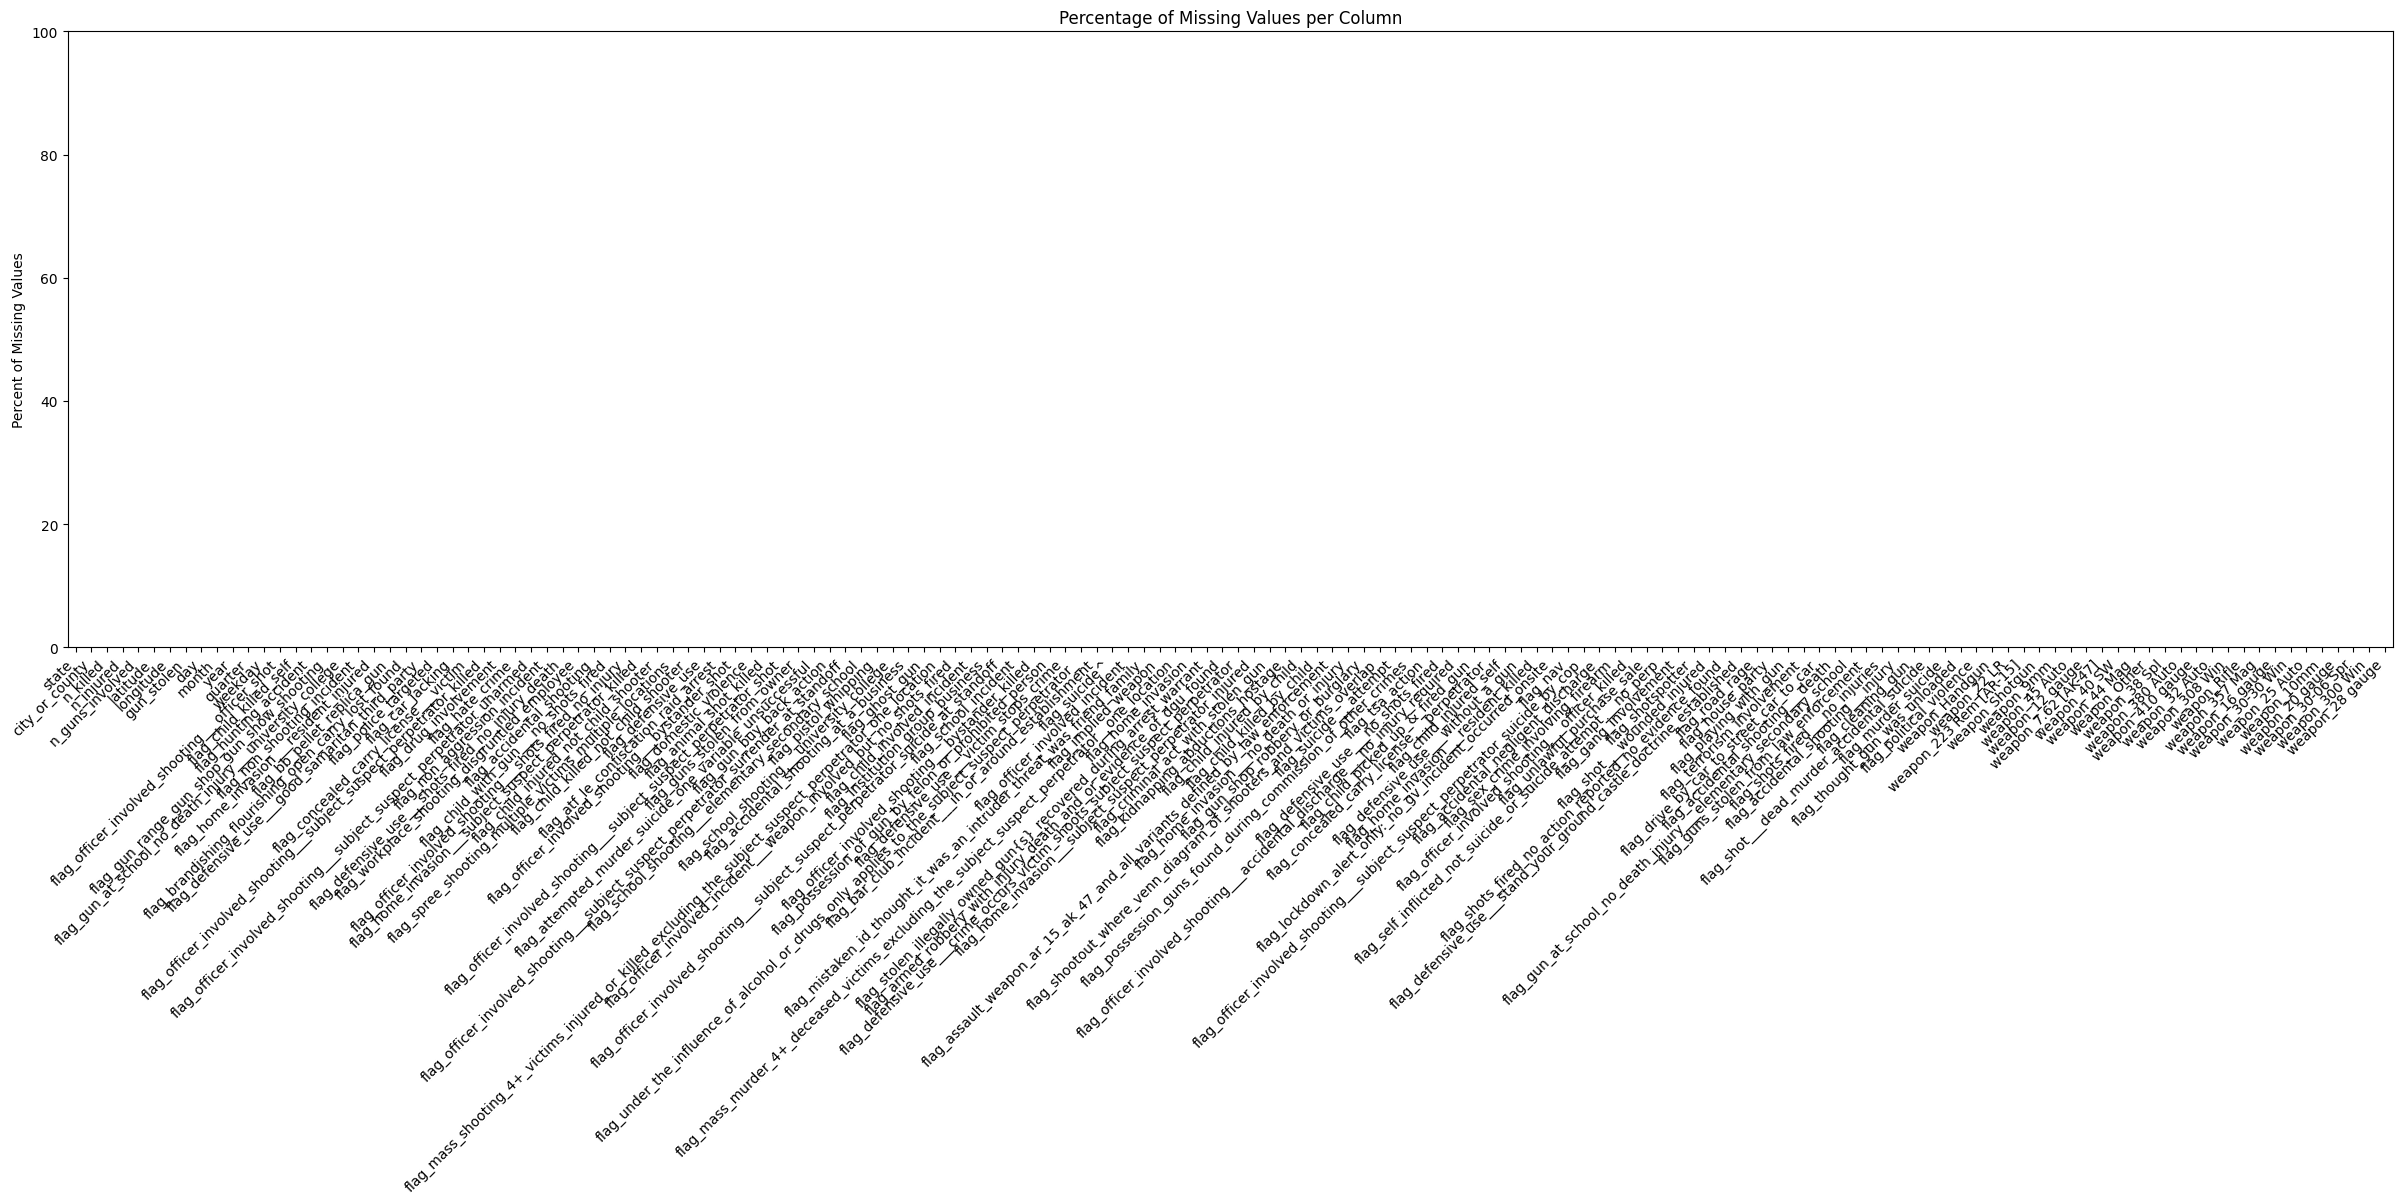

In [35]:
missing_values = df.isnull().sum() * 100 / len(df)
plt.figure(figsize=(30, 8))
missing_values.plot(kind='bar')
plt.title('Percentage of Missing Values per Column')
plt.ylabel('Percent of Missing Values')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 100)
plt.show()

In [36]:
print("Number of rows: " + str(len(df)))
print("Number of columns: " + str(len(df.columns)))

Number of rows: 239677
Number of columns: 148


We have managed to get rid of all the unknown values, keeping the size of the dataframe intact. However, the number of columns increased from 29 to 148, due to mapping of the columns consisting of multiple values.
If we were to drop the samples with missing values, we would probably be left with only 10-20% of the samples which is relatively small sample size for this task.

# Linear regression modelling

We will perform the linear regression for two attributes: 

* n_killed,
* n_injured.

## Input data selection

Before that, the features are transformed depending on their type. Numeric features are accepted as they were, and caterogical features are encoded using OneHotEncoder so that they are represented by unique numerical values, making them representative for linear regression model.

In [37]:
features = [col for col in df.columns if col not in ("n_killed", "n_injured")]
X = df[features]

y_killed = df['n_killed']
y_injured = df['n_injured']

categorical_features = ['day', 'month', 'year', 'quarter', 'weekday', 'state', 'city_or_county', 'gun_stolen', *[x for x in df.columns if x.startswith("flag_")]]
numeric_features = ['latitude', 'longitude', 'n_guns_involved', *[x for x in df.columns if x.startswith("weapon_")]]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

Then dataset is splitted into testing and training sets.

In [38]:
X_injured_train, X_injured_test, y_injured_train, y_injured_test = train_test_split(X, y_injured, test_size=0.2, random_state=42)
X_killed_train, X_killed_test, y_killed_train, y_killed_test = train_test_split(X, y_killed, test_size=0.2, random_state=42)

## Model fitting

Then a pipeline is made for each model, consisting of preprocessing part (mainly onehot encoder as numerical values are left as they are) and Linear Regression. After that each model is fitted to the data.

In [39]:
injured_model = make_pipeline(preprocessor, LinearRegression())
killed_model = make_pipeline(preprocessor, LinearRegression())

injured_model.fit(X_injured_train, y_injured_train)
killed_model.fit(X_killed_train, y_killed_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['latitude', 'longitude',
                                                   'n_guns_involved',
                                                   'weapon_Handgun',
                                                   'weapon_22 LR',
                                                   'weapon_223 Rem [AR-15]',
                                                   'weapon_Shotgun',
                                                   'weapon_9mm',
                                                   'weapon_45 Auto',
                                                   'weapon_12 gauge',
                                                   'weapon_7.62 [AK-47]',
                                                   'weapon_40 SW',
                                                   'weapon_44 Mag',
                                                   'weapon_Other',
                                                   'weapon_38 Spl',
                                                   'weapon_380 Auto',
                                                   'wea...
                                                   'flag_drug_involvement',
                                                   'flag_hate_crime',
                                                   'flag_officer_involved_shooting___subject_suspect_perpetrator_unarmed',
                                                   'flag_non_aggression_incident',
                                                   'flag_defensive_use___shots_fired_no_injury_death',
                                                   'flag_workplace_shooting_disgruntled_employee',
                                                   'flag_accidental_shooting',
                                                   'flag_child_with_gun___no_shots_fired', ...])])),
                ('linearregression', LinearRegression())])

## Model results - coefficients

First step in the process of checking the model's specifics is accessing the list of all features combined, used in the process of training the model.

In [40]:
onehot_categories = injured_model.named_steps['columntransformer'].named_transformers_['cat'].categories_
numeric_features_out = numeric_features
categorical_features_out = [f"{feature}_{category}" for feature, categories in zip(categorical_features, onehot_categories) for category in categories]
all_features = numeric_features_out + categorical_features_out

In the next step, we can access the calculated coeffiecients and intercepts for each feature specifically, for both models.
We would like to print the list of TOP10 features that have the highest impact on the outcome of prediction.

In [41]:
coefficients_injured = injured_model.named_steps['linearregression'].coef_
intercept_injured = injured_model.named_steps['linearregression'].intercept_

summary_injured = pd.DataFrame({
    'Feature': all_features,
    'Coefficient': coefficients_injured
})

# Sort by absolute value of coefficients
summary_injured['AbsCoefficient'] = summary_injured['Coefficient'].abs()
summary_injured_sorted = summary_injured.sort_values(by='AbsCoefficient', ascending=False).drop(columns='AbsCoefficient')

print("Intercept (Injured Model):", intercept_injured)
print(summary_injured_sorted.head(10))

Intercept (Injured Model): 4.656939408968165
                                       Feature  Coefficient
10503        city_or_county_Sutherland Springs    16.290900
8619   city_or_county_Pompano Beach (Parkland)     6.519739
1656                    city_or_county_Capulin    -3.157233
4214        city_or_county_Goleta (Isla Vista)     3.125264
5520                 city_or_county_Kilmichael    -3.061953
7128                  city_or_county_Montesano    -2.937032
6194             city_or_county_Lookout Valley    -2.930155
3443             city_or_county_Emery (county)    -2.922804
1231         city_or_county_Bradley (Callison)    -2.706231
2185             city_or_county_Clearlake Oaks    -2.563049


In [42]:
coefficients_killed = killed_model.named_steps['linearregression'].coef_
intercept_killed = killed_model.named_steps['linearregression'].intercept_

summary_killed = pd.DataFrame({
    'Feature': all_features,
    'Coefficient': coefficients_killed
})

summary_killed['AbsCoefficient'] = summary_killed['Coefficient'].abs()
summary_killed_sorted = summary_killed.sort_values(by='AbsCoefficient', ascending=False).drop(columns='AbsCoefficient')

print("Intercept (Killed Model):", intercept_killed)
print(summary_killed_sorted.head(10))

Intercept (Killed Model): 5.5201850960292616
                                                 Feature  Coefficient
10503                  city_or_county_Sutherland Springs    21.165083
8619             city_or_county_Pompano Beach (Parkland)     5.149946
11293                city_or_county_Washington Navy Yard     2.902897
3443                       city_or_county_Emery (county)    -2.590482
7128                            city_or_county_Montesano    -2.563293
8435                              city_or_county_Piketon     2.474830
12416  flag_mass_murder_4+_deceased_victims_excluding...     2.006449
12415  flag_mass_murder_4+_deceased_victims_excluding...    -2.006449
245                                city_or_county_Alexis     1.966166
1147                            city_or_county_Bondurant     1.963578


As we can see above, the feature_category which has the highest impact on the outcome of both `n_killed` and `n_injured` was the value "Sutherland Springs" in the column `city_or_county`.

There is a noticeable effect of the `city_or_county` column on the outcome. It seems that the `n_killed` and `n_injured` is highly connected with the location of the incident.

## Evaluation of the linear regression model

In [43]:
y_inj_pred = injured_model.predict(X_injured_test)
y_kill_pred = killed_model.predict(X_killed_test)

mse_injured = metrics.mean_squared_error(y_inj_pred, y_injured_test)
mse_killed = metrics.mean_squared_error(y_kill_pred, y_killed_test)

mean_absolute_error_injured = metrics.mean_absolute_error(y_inj_pred, y_injured_test) 
mean_absolute_error_killed = metrics.mean_absolute_error(y_kill_pred, y_killed_test) 

explained_variance_injured = metrics.explained_variance_score(y_inj_pred, y_injured_test)
explained_variance_killed = metrics.explained_variance_score(y_kill_pred, y_killed_test)

r2_injured = metrics.r2_score(y_injured_test, y_inj_pred)
r2_killed = metrics.r2_score(y_killed_test, y_kill_pred)

print("Injured linear regression:")
print(f'Mean squared error: {mse_injured}')
print(f'Mean absolute error: {mean_absolute_error_injured}')
print(f'Explained variance: {explained_variance_injured}')
print("R² Score for Injured Predictions:", r2_injured)
print("-------------------------------------------")
print("Killed linear regression:")
print(f'Mean squared error: {mse_killed}')
print(f'Mean absolute error: {mean_absolute_error_killed}')
print(f'Explained variance: {explained_variance_killed}')
print("R² Score for Killed Predictions:", r2_killed)

Injured linear regression:
Mean squared error: 0.11983282164868704
Mean absolute error: 0.15896481113114214
Explained variance: 0.7084321250205264
R² Score for Injured Predictions: 0.7658882650829137
-------------------------------------------
Killed linear regression:
Mean squared error: 0.026848650924651166
Mean absolute error: 0.04562536000154688
Explained variance: 0.8866311318005698
R² Score for Killed Predictions: 0.8949789364076355


As we can see, the models performance looks promising. However, the `n_killed` linear regression model seems to perform better with mean square error of 0.027 and R^2 score of 0.89 which shows that the model explains 89% of the variability of number of killed people. These results are quite satisfactory, however can be improved.

The next step is testing the models' work:

In [44]:
# Set the seed for reproducibility
np.random.seed(10)

# Number of samples to compare
num_samples = 10

y_injured_test_array = y_injured_test.to_numpy(dtype="float32")
y_killed_test_array = y_killed_test.to_numpy(dtype="float32")

# Generate random indices
random_indices = np.random.choice(len(y_injured_test_array), num_samples, replace=False)

# Print the comparison for injured predictions
print("\nComparison of Injured Predictions and Actual Values:")
for idx in random_indices:
    print(f"Index: {idx}, Predicted: {y_inj_pred[idx]}, Actual: {y_injured_test_array[idx]}, Difference: {abs(y_inj_pred[idx]-y_injured_test_array[idx])}")

# Print the comparison for killed predictions
print("\nComparison of Killed Predictions and Actual Values:")
for idx in random_indices:
    print(f"Index: {idx}, Predicted: {y_kill_pred[idx]}, Actual: {y_killed_test_array[idx]}, Difference: {abs(y_kill_pred[idx]-y_killed_test_array[idx])}")


Comparison of Injured Predictions and Actual Values:
Index: 28059, Predicted: -0.051393590414333445, Actual: 0.0, Difference: 0.051393590414333445
Index: 34957, Predicted: 1.0299694997712718, Actual: 1.0, Difference: 0.029969499771271835
Index: 5639, Predicted: -0.0057324621779333285, Actual: 0.0, Difference: 0.0057324621779333285
Index: 34688, Predicted: -0.018783170595312093, Actual: 0.0, Difference: 0.018783170595312093
Index: 17834, Predicted: -0.01944500451311626, Actual: 0.0, Difference: 0.01944500451311626
Index: 30789, Predicted: 0.02599264464711748, Actual: 0.0, Difference: 0.02599264464711748
Index: 13259, Predicted: 1.0801218387691511, Actual: 1.0, Difference: 0.08012183876915113
Index: 11296, Predicted: 0.06084414664740212, Actual: 0.0, Difference: 0.06084414664740212
Index: 42540, Predicted: -0.0420744254980745, Actual: 0.0, Difference: 0.0420744254980745
Index: 8827, Predicted: 1.1074601380033724, Actual: 1.0, Difference: 0.1074601380033724

Comparison of Killed Predicti

In this step we have shown randomized rows, and compared the predicted values with the actual values.

# Alternative linear regression model

## Input data selection
For the alternative model of linear regression we first decided to drop state, city or county, weekday, quarter columns as they are derived from other data (date, longitude, latitude) and can cause data noise.
<br>
Another step we have taken is slightly changing the preprocessing, by adding normalization for numeric features. The values of flag columns are not normalized, as they are always either 0 or 1. The categorical features are still mapped using OneHotEncoder.
The data is copied into X_alt to not drop columns from the original dataset, as they may still be useful in later exploration.

In [45]:
features_to_drop = ['state', 'weekday', 'quarter', 'city_or_county', 'n_injured', 'n_killed']
categorical_features = ['day', 'month', 'year', 'gun_stolen', *[x for x in df.columns if x.startswith("flag_")]]
numeric_features = ['latitude', 'longitude', 'n_guns_involved']
flags = [*[x for x in df.columns if x.startswith("weapon_")]]

X_alt = df.copy().drop(columns = features_to_drop, inplace = False)
preprocessor_alt = ColumnTransformer(
    transformers=[
        ('flags', 'passthrough', flags),
        ('normalized_num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

Again we have to divide the dataset into training and test sets, with dropped chosen columns.

In [46]:
X_alt_injured_train, X_alt_injured_test, y_alt_injured_train, y_alt_injured_test = train_test_split(X_alt, y_injured, test_size=0.2, random_state=42)
X_alt_killed_train, X_alt_killed_test, y_alt_killed_train, y_alt_killed_test = train_test_split(X_alt, y_killed, test_size=0.2, random_state=42)

## Fitting the model

Now, prepare the pipeline with updated preprocessor and fit the data.

In [47]:
injured_model_alt = make_pipeline(preprocessor_alt, LinearRegression())
killed_model_alt = make_pipeline(preprocessor_alt, LinearRegression())

injured_model_alt.fit(X_alt_injured_train, y_alt_injured_train)
killed_model_alt.fit(X_alt_killed_train, y_alt_killed_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('flags', 'passthrough',
                                                  ['weapon_Handgun',
                                                   'weapon_22 LR',
                                                   'weapon_223 Rem [AR-15]',
                                                   'weapon_Shotgun',
                                                   'weapon_9mm',
                                                   'weapon_45 Auto',
                                                   'weapon_12 gauge',
                                                   'weapon_7.62 [AK-47]',
                                                   'weapon_40 SW',
                                                   'weapon_44 Mag',
                                                   'weapon_Other',
                                                   'weapon_38 Spl',
                                                   'weapon_380 Auto',
                                                   'weapon_410 gauge',
                                                   'weapon_32 Auto',
                                                   'weapon_3...
                                                   'flag_workplace_shooting_disgruntled_employee',
                                                   'flag_accidental_shooting',
                                                   'flag_child_with_gun___no_shots_fired',
                                                   'flag_officer_involved_shooting___shots_fired_no_injury',
                                                   'flag_home_invasion___subject_suspect_perpetrator_killed',
                                                   'flag_child_injured_not_child_shooter',
                                                   'flag_spree_shooting_multiple_victims_multiple_locations', ...])])),
                ('linearregression', LinearRegression())])

## Evaluation of the model

In [48]:
y_inj_pred_alt = injured_model_alt.predict(X_alt_injured_test)
y_kill_pred_alt = killed_model_alt.predict(X_alt_killed_test)

mse_injured_alt = metrics.mean_squared_error(y_inj_pred_alt, y_alt_injured_test)
mse_killed_alt = metrics.mean_squared_error(y_kill_pred_alt, y_alt_killed_test)

mean_absolute_error_injured_alt = metrics.mean_absolute_error(y_inj_pred_alt, y_alt_injured_test) 
mean_absolute_error_killed_alt = metrics.mean_absolute_error(y_kill_pred_alt, y_alt_killed_test) 

explained_variance_injured_alt = metrics.explained_variance_score(y_inj_pred_alt, y_alt_injured_test)
explained_variance_killed_alt = metrics.explained_variance_score(y_kill_pred_alt, y_alt_killed_test)

r2_injured_alt = metrics.r2_score(y_inj_pred_alt, y_alt_injured_test)
r2_killed_alt = metrics.r2_score(y_kill_pred_alt, y_alt_killed_test)

print("Injured alternative linear regression:")
print(f'Mean squared error: {mse_injured_alt}')
print(f'Mean absolute error: {mean_absolute_error_injured_alt}')
print(f'Explained variance: {explained_variance_injured_alt}')
print("R² Score for Injured Predictions:", r2_injured_alt)
print("-------------------------------------------")
print("Killed alternative linear regression:")
print(f'Mean squared error: {mse_killed_alt}')
print(f'Mean absolute error: {mean_absolute_error_killed_alt}')
print(f'Explained variance: {explained_variance_killed_alt}')
print("R² Score for Killed Predictions:", r2_killed_alt)

Injured alternative linear regression:
Mean squared error: 0.1147212282610081
Mean absolute error: 0.14649053395695238
Explained variance: 0.7159041126573267
R² Score for Injured Predictions: 0.7159037077280853
-------------------------------------------
Killed alternative linear regression:
Mean squared error: 0.02418959777209386
Mean absolute error: 0.03922800646013797
Explained variance: 0.8970763242144758
R² Score for Killed Predictions: 0.8970762420581625


This alternative model is slightly more accurate and has lower mean squared error in predicting both `n_killed` and `n_injured`. That is most likely due to reduced noise in the data.

# Alternative approach - tree classifier

For the alternative modeling algorithm we decided to give a try to decision tree classifier. As `n_injured` and `n_killed` are a discrete numerical variables, they are possible to predict also by a decision tree.

As always, we started with selecting the columns for fitting the model into data, splitting data intro training and testing sets, and preparing pipelines for the models.\\

## Input data selection

In [49]:
X = df.copy().drop(columns=['n_injured', 'n_killed'])
y_injured = df['n_injured']
y_killed = df['n_killed']

categorical_features = ['day', 'month', 'year', 'quarter', 'weekday', 'state', 'city_or_county', 'gun_stolen', *[x for x in df.columns if x.startswith("flag_")]]
numeric_features = ['latitude', 'longitude', 'n_guns_involved', *[x for x in df.columns if x.startswith("weapon_")]]

preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', 'passthrough', numeric_features),
        ('categorical', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

X_injured_train, X_injured_test, y_injured_train, y_injured_test = train_test_split(X, y_injured, test_size=0.2, random_state=21)
X_killed_train, X_killed_test, y_killed_train, y_killed_test = train_test_split(X, y_killed, test_size=0.2, random_state=21)

## Model fitting

The next step is the actual training of the models on the training dataset.

In [50]:
injured_tree_model = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', DecisionTreeClassifier(random_state=42))])
killed_tree_model = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', DecisionTreeClassifier(random_state=42))])

injured_tree_model.fit(X_injured_train, y_injured_train)
killed_tree_model.fit(X_killed_train, y_killed_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical', 'passthrough',
                                                  ['latitude', 'longitude',
                                                   'n_guns_involved',
                                                   'weapon_Handgun',
                                                   'weapon_22 LR',
                                                   'weapon_223 Rem [AR-15]',
                                                   'weapon_Shotgun',
                                                   'weapon_9mm',
                                                   'weapon_45 Auto',
                                                   'weapon_12 gauge',
                                                   'weapon_7.62 [AK-47]',
                                                   'weapon_40 SW',
                                                   'weapon_44 Mag',
                                                   'weapon_Other',
                                                   'weapon_38 Spl',
                                                   'weapon_380 Auto',
                                                   'we...
                                                   'flag_drug_involvement',
                                                   'flag_hate_crime',
                                                   'flag_officer_involved_shooting___subject_suspect_perpetrator_unarmed',
                                                   'flag_non_aggression_incident',
                                                   'flag_defensive_use___shots_fired_no_injury_death',
                                                   'flag_workplace_shooting_disgruntled_employee',
                                                   'flag_accidental_shooting',
                                                   'flag_child_with_gun___no_shots_fired', ...])])),
                ('classifier', DecisionTreeClassifier(random_state=42))])

## Model results - the most important features

In the next section, there are shown top 10 most important features for both of the models - the ones' affecting outcome of the prediction the most.

In [51]:
numeric_feature_names = numeric_features
categorical_feature_names = injured_tree_model.named_steps['preprocessor'].named_transformers_['categorical'].get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([numeric_feature_names, categorical_feature_names])


feature_importances_injured = injured_tree_model.named_steps['classifier'].feature_importances_
summary_injured = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': feature_importances_injured
})
summary_injured_sorted = summary_injured.sort_values(by='Importance', ascending=False)

print("Feature Importances (Injured Model):")
print(summary_injured_sorted.head(10))
print("\n--------------------------------------------------------------------\n")

feature_importances_killed = killed_tree_model.named_steps['classifier'].feature_importances_
summary_killed = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': feature_importances_killed
})
summary_killed_sorted = summary_killed.sort_values(by='Importance', ascending=False)

print("Feature Importances (Killed Model):")
print(summary_killed_sorted.head(10))

Feature Importances (Injured Model):
                                                 Feature  Importance
12416                      flag_shot___wounded_injured_1    0.724149
12310                             flag_pistol_whipping_0    0.030331
0                                               latitude    0.025426
1                                              longitude    0.025159
12318  flag_mass_shooting_4+_victims_injured_or_kille...    0.010613
12444       flag_shot___dead_murder_accidental_suicide_1    0.002854
75                                             year_2016    0.001934
86                                             weekday_4    0.001922
84                                             weekday_2    0.001879
87                                             weekday_5    0.001878

--------------------------------------------------------------------

Feature Importances (Killed Model):
                                                 Feature  Importance
12444       flag_shot___dead

## Model evaluation

The last step of the model processing is its evaluation. As always, we are calculating four measures for each of the model: MSE, MAE, R^2 score and explained variance.

In [53]:
y_injured_tree_pred = injured_tree_model.predict(X_injured_test)
y_killed_tree_pred = killed_tree_model.predict(X_killed_test)


mse_tree_injured = metrics.mean_squared_error(y_injured_test, y_injured_tree_pred)
mae_tree_injured = metrics.mean_absolute_error(y_injured_test, y_injured_tree_pred)
r2_tree_injured = metrics.r2_score(y_injured_test, y_injured_tree_pred)
explained_variance_tree_injured = metrics.explained_variance_score(y_injured_test, y_injured_tree_pred)

print("Injured Tree Model Evaluation Metrics:")
print(f"Mean squared error: {mse_tree_injured}")
print(f"Mean absolute error: {mae_tree_injured}")
print(f"R² score: {r2_tree_injured}")
print(f"Explained Variance: {explained_variance_tree_injured}")
print("-------------------------------------------")


mse_tree_killed = metrics.mean_squared_error(y_killed_test, y_killed_tree_pred)
mae_tree_killed = metrics.mean_absolute_error(y_killed_test, y_killed_tree_pred)
r2_tree_killed = metrics.r2_score(y_killed_test, y_killed_tree_pred)
explained_variance_tree_killed = metrics.explained_variance_score(y_killed_test, y_killed_tree_pred)

print("Killed Model Evaluation Metrics:")
print(f"Mean squared error: {mse_tree_killed}")
print(f"Mean absolute error: {mae_tree_killed}")
print(f"R² score: {r2_tree_killed}")
print(f"Explained Variance: {explained_variance_tree_killed}")

Injured Tree Model Evaluation Metrics:
Mean squared error: 0.19636598798397864
Mean absolute error: 0.12994409212283045
R² score: 0.6236285759486973
Explained Variance: 0.6238584793511739
-------------------------------------------
Killed Model Evaluation Metrics:
Mean squared error: 0.03673648197596796
Mean absolute error: 0.028600634178905206
R² score: 0.8569455727051178
Explained Variance: 0.8569687707764156


As we can see, the first model (for `n_injured` predictions) performs definitely worse than the linear regression. However the second one (for `n_killed`) seems to have a great performance with high explanation of variability and relatively low error measures.